In [1]:
import sys
sys.path.append('..')

In [2]:
from typing import Optional, List
from pathlib import Path
from collections import defaultdict
from datetime import datetime
from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tqdm.notebook import tqdm, trange
from scipy.optimize import minimize

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from myutils.stats import corrcoef, acfunc
from myutils.matplotlib import matplotlib_seaborn_style

from src.missing_values import impute_average
from src.pca import ImputePCA
from src.rzd import PlacePriceModel

matplotlib_seaborn_style()

In [3]:
results_dir = Path('../data/prediction')
results_dir.mkdir(exist_ok=True)

figures_dir = results_dir / 'figures'
figures_dir.mkdir(exist_ok=True)

In [4]:
data = pd.read_csv('../data/data.csv', parse_dates=['date'], encoding='utf-8')

data['weekday'] = data['date'].dt.weekday
data['day_name'] = data['date'].dt.day_name()

weekdays = data[['weekday', 'day_name']].drop_duplicates().sort_values(by='weekday')\
    .set_index('weekday')['day_name'].to_dict()

data.head(2)

,date,days,places,price,num,class,train,departure_hour,arrival_hour,places_frac,weekday,day_name
0,2021-04-12,1,28.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0.200000,0,Monday
1,2021-04-13,1,52.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0.371429,1,Tuesday


In [5]:
train_clusters = pd.read_csv('../data/weekends/weekly_avg_pc_clusters.csv', index_col=0)['cluster'].sort_index()

train_clusters.head()

train
001А-Купе    1
002А-Купе    2
005А-СВ      1
006А-СВ      2
701Н-СВ      0
Name: cluster, dtype: int64

In [6]:
dates = data['date'].unique()
dates.sort()

dates[:6]

array(['2021-04-12T00:00:00.000000000', '2021-04-13T00:00:00.000000000',
       '2021-04-14T00:00:00.000000000', '2021-04-15T00:00:00.000000000',
       '2021-04-16T00:00:00.000000000', '2021-04-17T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [7]:
places = data.pivot(index=['train', 'date'], columns='days', values='places_frac').sort_index()

places.head()

days                        1         2         3         4         5   \
train     date                                                           
001А-Купе 2021-04-12  0.200000  0.228571  0.235714  0.514286  0.607143   
          2021-04-13  0.371429  0.392857  0.400000  0.400000  0.592857   
          2021-04-14  0.650000  0.735714  0.757143  0.764286  0.771429   
          2021-04-15  0.521429  0.664286  0.742857  0.750000  0.764286   
          2021-04-16  0.342857  0.457143  0.521429  0.585714  0.650000   

days                        6         7         8         9         10  ...  \
train     date                                                          ...   
001А-Купе 2021-04-12  0.707143  0.735714  0.750000  0.778571  0.850000  ...   
          2021-04-13  0.650000  0.735714  0.750000  0.757143  0.757143  ...   
          2021-04-14  0.821429  0.850000  0.900000       NaN  0.907143  ...   
          2021-04-15  0.764286  0.792857  0.807143  0.814286  0.835714  ...   
          2021-04-16  0.685714  0.685714  0.742857  0.807143  0.857143  ...   

days                  80  81  82  83  84  85  86  87  88  89  
train     date                                                
001А-Купе 2021-04-12 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
          2021-04-13 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
          2021-04-14 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
          2021-04-15 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
          2021-04-16 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[5 rows x 89 columns]

## Прогнозирование заполняемости поездов

__Общая постановка задачи__. Имеются данные о доле свободных мест в поездах за какой-то промежуток дней до отправления, например, за 30-45 дней до отправления. Требуется предсказать, какая будет доля свободных мест, например, за 1-29 дней до отправления.

В такой постановке можно, например, имея динамику заполняемости поезда за месяц до отправления, прогнозировать дальнейшую динамику заполняемости.

__Внимание!__ Ниже будет очень много очень плохого кода, потому что я его не успел почистить. Сорян......

### Подход 1. Тупо регрессия

Самое простое, что можно сделать — это тупо обучить отдельную регрессию для каждого из 1-29 дней до отправления.

Особенности модели ниже:

1. В `x` (и на фите, и на предикте) заполняем пропуски с помощью `impute_average`.
2. Стратификация: если указана стратификация объектов из выборки (например, стратификация по поездам, по кластерам из предыдущих ноутбуков), то для каждой страты обучаем отдельную модель.

In [8]:
class Regressor:
    def __init__(self, base_regressor=SVR):
        self.base_regressor = base_regressor
        
        self.n_features = None
        self.n_targets = None
        
        self.regressors = None
        
    def fit(self, x: np.ndarray, y: np.ndarray, strata: Optional[np.ndarray] = None) -> 'Regressor':
        if strata is None:
            strata = np.zeros(x.shape[0])
        
        self.n_features = x.shape[1]
        self.n_targets = y.shape[1]
        
        x = impute_average(x, lim=(0, 1))
        
        unique_strata = np.unique(strata)
        keys = list(product(unique_strata, range(self.n_targets)))
        self.regressors = dict.fromkeys(keys)
        
        for stratum, i in keys:
            x_ = x[strata == stratum]
            y_ = y[strata == stratum, i]
            
            x_ = x_[~np.isnan(y_)]
            y_ = y_[~np.isnan(y_)]
            
            regressor = self.base_regressor()
            regressor.fit(x_, y_)
            self.regressors[(stratum, i)] = regressor
            
        return self
    
    def predict(self, x: np.ndarray, strata: Optional[np.ndarray] = None) -> np.ndarray:
        if strata is None:
            strata = np.zeros(x.shape[0])
        
        x = impute_average(x, lim=(0, 1))
        
        y_pred = np.empty((x.shape[0], self.n_targets))
        
        for stratum, i in product(np.unique(strata), range(self.n_targets)):
            y_pred_ = self.regressors[(stratum, i)].predict(x[strata == stratum])
            
            y_pred[strata == stratum, i] = y_pred_
            
        return y_pred

### Подход 2. Регрессия на главных компонентах

Более хитрый метод:

1. В процессе обучения строим модель PCA (не только на 30-45 днях до отправления, а на всех доступных) и модель регрессии, предсказывающую значение ГК по 30-45 дням до отправления).
2. В процессе инференса предсказываем по входным данным значение ГК и используем его для восстановления данных (т.е. реверс-инженирим модель PCA).

Тут, как и выше, заполняются пропуски и доступна стратификация.

In [9]:
class PrincipalComponentRegressor:
    def __init__(self, n_components: int = 1, base_regressor=SVR):
        self.n_components = n_components
        self.base_regressor = base_regressor

        self.n_pca_features = None
        self.pcas = None
        
        self.n_regressor_features = None
        self.regressors = None
        
    def fit_predict_pca(self, x: np.ndarray, strata: Optional[np.ndarray] = None) -> np.ndarray:
        if strata is None:
            strata = np.zeros(x.shape[0])
        
        x = impute_average(x, lim=(0, 1))
        
        self.n_pca_features = x.shape[1]
        
        unique_strata = np.unique(strata)
        self.pcas = dict.fromkeys(unique_strata)
        
        components = np.empty((x.shape[0], self.n_components))
        
        for stratum in unique_strata:
            pca = ImputePCA(n_components=self.n_components)
            x_ = x[strata == stratum]
            
            stratum_components = pca.fit_predict(x_)
            components[strata == stratum] = stratum_components
            
            self.pcas[stratum] = pca
            
        return components
    
    def reconstruct_pca(self, components: np.ndarray, strata: Optional[np.ndarray] = None):
        if strata is None:
            strata = np.zeros(components.shape[0])
        
        x = np.empty((components.shape[0], self.n_pca_features))
        
        for stratum in np.unique(strata):
            stratum_components = components[strata == stratum]
            x_ = self.pcas[stratum].reconstruct(stratum_components)
            
            x[strata == stratum] = x_
            
        return x
    
    def fit_regressor(self, x: np.ndarray, y: np.ndarray, strata: Optional[np.ndarray] = None):
        if strata is None:
            strata = np.zeros(x.shape[0])
        
        x = impute_average(x, lim=(0, 1))
        
        assert y.shape[1] == self.n_components
        
        self.n_regressor_features = x.shape[1]
        
        unique_strata = np.unique(strata)
        keys = list(product(unique_strata, range(y.shape[1])))
        
        self.regressors = dict.fromkeys(keys)
        
        for stratum, i in keys:
            x_ = x[strata == stratum]
            y_ = y[strata == stratum, i]

            regressor = self.base_regressor()
            regressor.fit(x_, y_)
            
            self.regressors[(stratum, i)] = regressor

    def predict_regressor(self, x: np.ndarray, strata: Optional[np.ndarray] = None) -> np.ndarray:
        if strata is None:
            strata = np.zeros(x.shape[0])
        
        x = impute_average(x, lim=(0, 1))
        
        y_pred = np.empty((x.shape[0], self.n_components))
        
        for stratum, i in product(np.unique(strata), range(self.n_components)):
            x_ = x[strata == stratum]
            y_pred_ = self.regressors[(stratum, i)].predict(x_)
            
            y_pred[strata == stratum, i] = y_pred_
            
        return y_pred
    
    def fit(
            self,
            x_pca: np.ndarray,
            x_regressor: np.ndarray,
            strata_pca: Optional[np.ndarray] = None,
            strata_regressor: Optional[np.ndarray] = None,
    ) -> 'PrincipalComponentRegressor':
        components = self.fit_predict_pca(x_pca, strata_pca)
        self.fit_regressor(x_regressor, components, strata_regressor)
        
        return self
    
    def predict(
            self,
            x: np.ndarray,
            strata_pca: Optional[np.ndarray] = None,
            strata_regressor: Optional[np.ndarray] = None,
    ) -> np.ndarray:
        components_pred = self.predict_regressor(x, strata_regressor)
        x_pred = self.reconstruct_pca(components_pred, strata_pca)
        
        return x_pred

### Подход 3. Оптимизация на ГК

Подход тоже использует ГК, но является куда более простым:

1. На трейне просто обучаем PCA.
2. На инференсе с помощью одномерной оптимизации подбираем значение ГК $a$ так, чтобы на 30-45 днях до отправления значения $\mu + a \cdot V$ были наиболее похожи на входные данные. Затем используем это значение $a$ для реверс-инжениринга PCA.

Ну и тут тоже заполнение пропусков и страты.

In [10]:
class PrincipalComponentOptimizer:
    def __init__(self):
        self.pcas = None
        
    def fit(self, x: np.ndarray, strata: Optional[np.ndarray] = None) -> 'PrincipalComponentOptimizer':
        if strata is None:
            strata = np.zeros(x.shape[0])
        
        x = impute_average(x, lim=(0, 1))
        
        unique_strata = np.unique(strata)
        self.pcas = dict.fromkeys(unique_strata)
        
        for stratum in unique_strata:
            pca = ImputePCA(n_components=1)
            x_ = x[strata == stratum]
            
            pca.fit_predict(x_)
            self.pcas[stratum] = pca
            
        return self
        
    def predict(
            self,
            x: np.ndarray,
            cols: np.ndarray,
            strata: Optional[np.ndarray] = None,
    ) -> np.ndarray:
        x = impute_average(x)
        
        def func(a: np.ndarray, x0: np.ndarray, stratum):
            x1 = self.pcas[stratum].reconstruct(a)[cols]
            
            return ((x1 - x0) ** 2).mean() ** 0.5
        
        y_pred = []
        
        for x0, stratum in zip(x, strata):
            res = minimize(func, np.array([0]), args=(x0, stratum))
            assert res.success
            a = res.x
            y_pred.append(self.pcas[stratum].reconstruct(a))
            
        y_pred = np.array(y_pred)
        
        return y_pred

Отметим, что подходы 1 и 2 в принципе позволяют ещё использовать дополнительные признаки (например, какие-нибудь внешние данные) на этапе обучения и инференса регрессионных моделей. На момент написания документации это тут не реализовано, но можно сделать.

## Тесты

In [11]:
x = places.values

cols = np.arange(45)  # столбцы, которые будут использованы
fit_cols = cols[-15:]  # столбцы для фита
predict_cols = cols[:-15]  # столбцы для предикта

x_pca = x[:, cols]  # для обучения PCA используются все `cols`
x_regressor = x[:, fit_cols]
y = x[:, predict_cols]

# выкидываем строки, для которых в матрицах `x_pca` и `x_regressor` менее 2 непустых значений
mask = ((~np.isnan(x_pca)).sum(axis=1) >= 2) & ((~np.isnan(x_regressor)).sum(axis=1) >= 2)

x = x[mask]
x_pca = x_pca[mask]
x_regressor = x_regressor[mask]
y = y[mask]

# стратификация по поездам (т.е. для каждого поезда отдельная модель)
train_strata = places.index.get_level_values(0).values[mask]

# стратификация по кластерам из `2_weekends.ipynb`
cluster_strata = places.index.get_level_values(0).map(train_clusters).values[mask]

Качество оцениваем по кросс-валидации. Придётся делать это вручную, потому что `PrincipalComponentRegressor`-у на фите надо подавать кучу всего.

Быстрый тест всех трёх подходов на одном фолде (чтобы не заморачиваться).

In [12]:
kfold = StratifiedKFold(5, shuffle=True)

for train_idx, test_idx in kfold.split(x, train_strata):
    x_pca_train = x_pca[train_idx]
    x_pca_test = x_pca[test_idx]
    
    x_regressor_train = x_regressor[train_idx]
    x_regressor_test = x_regressor[test_idx]
    
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    train_strata_train = train_strata[train_idx]
    train_strata_test = train_strata[test_idx]
    
    cluster_strata_train = cluster_strata[train_idx]
    cluster_strata_test = cluster_strata[test_idx]
    
    break

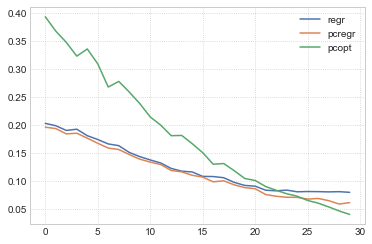

In [13]:
pcopt = PrincipalComponentOptimizer().fit(x_pca_train, train_strata_train)
regr = Regressor(base_regressor=SVR).fit(x_regressor_train, y_train, train_strata_train)
pcregr = PrincipalComponentRegressor(base_regressor=SVR)\
    .fit(x_pca_train, x_regressor_train, train_strata_train, train_strata_train)

y_pred = regr.predict(x_regressor_test, train_strata_test)
plt.plot(np.nanmean((y_test - y_pred) ** 2, axis=0) ** 0.5, label='regr')

y_pred = pcregr.predict(x_regressor_test, train_strata_test, train_strata_test)[:, predict_cols]
plt.plot(np.nanmean((y_test - y_pred) ** 2, axis=0) ** 0.5, label='pcregr')

y_pred = pcopt.predict(x_regressor_test, cols=fit_cols, strata=train_strata_test)[:, predict_cols]
plt.plot(np.nanmean((y_test - y_pred) ** 2, axis=0) ** 0.5, label='pcopt')

plt.legend()

Отдельно тестируем качество восстановления данных моделью PCA. По сути это то, как бы мы предсказывали значения из `x`, если бы была возможность предсказывать значения ГК со 100% точностью.

_Замечание._ В "рабочей" версии модели `PrincipalComponentRegressor` такое посчитать не получится, потому что тестовые данные не используются для обучения PCA, поэтому точные значения ГК на них мы и не знаем.

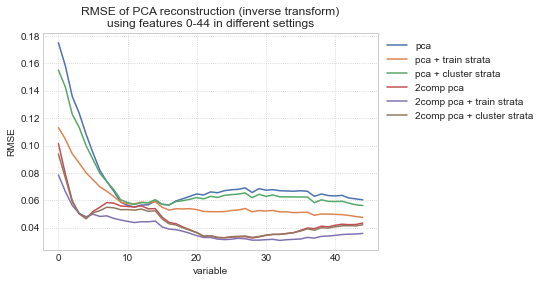

In [14]:
pcregr = PrincipalComponentRegressor()
pcs = pcregr.fit_predict_pca(x_pca)
x_pca_pred = pcregr.reconstruct_pca(pcs)

scores = np.nanmean((x_pca - x_pca_pred) ** 2, axis=0) ** 0.5
plt.plot(scores, label='pca')

pcregr = PrincipalComponentRegressor()
pcs = pcregr.fit_predict_pca(x_pca, train_strata)
x_pca_pred = pcregr.reconstruct_pca(pcs, train_strata)

scores = np.nanmean((x_pca - x_pca_pred) ** 2, axis=0) ** 0.5
plt.plot(scores, label='pca + train strata')

pcregr = PrincipalComponentRegressor()
pcs = pcregr.fit_predict_pca(x_pca, cluster_strata)
x_pca_pred = pcregr.reconstruct_pca(pcs, cluster_strata)

scores = np.nanmean((x_pca - x_pca_pred) ** 2, axis=0) ** 0.5
plt.plot(scores, label='pca + cluster strata')

pcregr = PrincipalComponentRegressor(2)
pcs = pcregr.fit_predict_pca(x_pca)
x_pca_pred = pcregr.reconstruct_pca(pcs)

scores = np.nanmean((x_pca - x_pca_pred) ** 2, axis=0) ** 0.5
plt.plot(scores, label='2comp pca')

pcregr = PrincipalComponentRegressor(2)
pcs = pcregr.fit_predict_pca(x_pca, train_strata)
x_pca_pred = pcregr.reconstruct_pca(pcs, train_strata)

scores = np.nanmean((x_pca - x_pca_pred) ** 2, axis=0) ** 0.5
plt.plot(scores, label='2comp pca + train strata')

pcregr = PrincipalComponentRegressor(2)
pcs = pcregr.fit_predict_pca(x_pca, cluster_strata)
x_pca_pred = pcregr.reconstruct_pca(pcs, cluster_strata)

scores = np.nanmean((x_pca - x_pca_pred) ** 2, axis=0) ** 0.5
plt.plot(scores, label='2comp pca + cluster strata')

plt.title(f'RMSE of PCA reconstruction (inverse transform)\n'
          f'using features {cols[0]}-{cols[-1]} in different settings')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('variable')
plt.ylabel('RMSE')

plt.savefig(figures_dir / f'pca_reconstruction_{cols[0]}_{cols[-1]}.pdf',
            transparent=True, bbox_inches='tight')

Видим, что стратификация по поездам даёт наилучшее качество. А стратификация по кластерам слабо влияет.

То же самое по отдельным поездам.

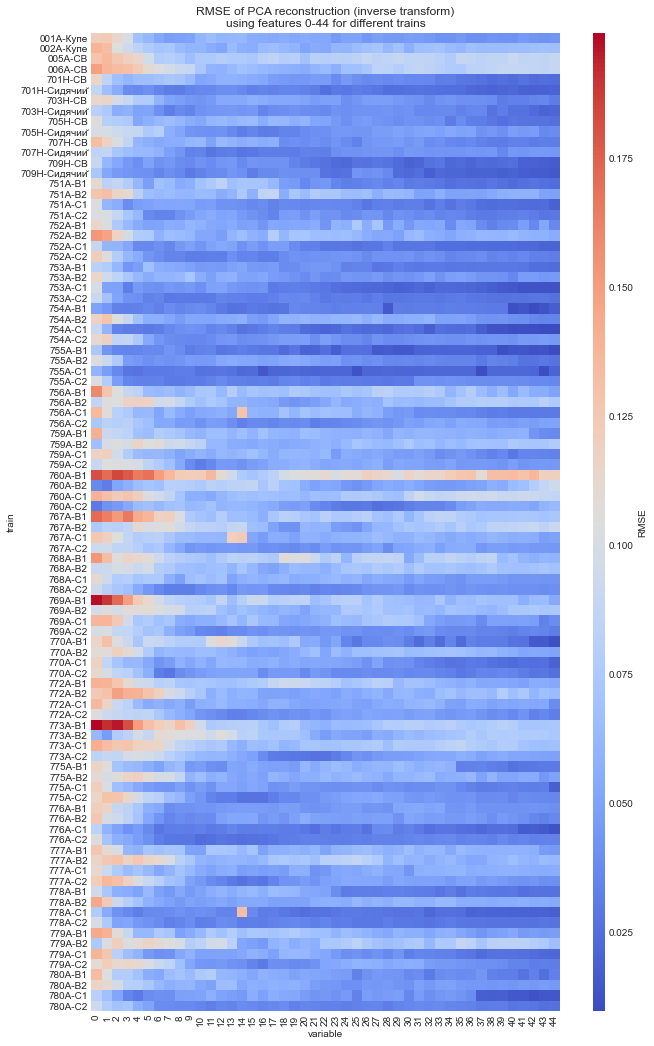

In [15]:
trains = places.index.get_level_values(0).unique()

scores = {}

for train in trains:
    mask = places.index.get_level_values(0) == train
    
    x = places[mask].values
    train_strata = places[mask].index.get_level_values(0).values
    cluster_strata = places[mask].index.get_level_values(0).map(train_clusters).values

    cols = np.arange(45)
    fit_cols = cols[-15:]
    predict_cols = cols[:-15]

    x_pca = x[:, cols]
    x_regressor = x[:, fit_cols]
    y = x[:, predict_cols]

    mask = ((~np.isnan(x_pca)).sum(axis=1) >= 3) & ((~np.isnan(x_regressor)).sum(axis=1) >= 3)

    x = x[mask]
    x_pca = x_pca[mask]
    x_regressor = x_regressor[mask]
    y = y[mask]

    pcregr = PrincipalComponentRegressor()
    pcs = pcregr.fit_predict_pca(x_pca)
    x_pca_pred = pcregr.reconstruct_pca(pcs)
    
    scores[train] = np.nanmean((x_pca - x_pca_pred) ** 2, axis=0) ** 0.5
    
scores = pd.DataFrame(scores).T

plt.figure(figsize=(12, 18))

sns.heatmap(scores, square=True, cmap='coolwarm', cbar_kws={'aspect': 80, 'label': 'RMSE'})

plt.xlabel('variable')
plt.ylabel('train')

plt.title(f'RMSE of PCA reconstruction (inverse transform)\n'
          f'using features {cols[0]}-{cols[-1]} for different trains')

plt.savefig(figures_dir / f'pca_reconstruction_{cols[0]}_{cols[-1]}_trains.pdf',
            transparent=True, bbox_inches='tight')

Теперь наоборот смотрим на качество сугубо предсказания ГК (т.е. это то, что было бы, если бы мы могли со 100% точностью восстанавливать данные по ГК).

_Замечание._ Тут единственный скользкий момент в том, что PCA может давать немного разные ГК в случае обучения на всех данных и только на обучающей выборке. Опять же, в "рабочей" версии `PrincipalComponentRegressor` мы не можем получить реальные значения ГК на тестовой выборке, поэтому в рабочем режиме воссоздать такой эксперимент не получится. Мы делаем это просто чтобы оценить качество всей этой модели на разных этапах.

In [20]:
x = places.values

cols = np.arange(45)  # столбцы, которые будут использованы
fit_cols = cols[-15:]  # столбцы для фита
predict_cols = cols[:-15]  # столбцы для предикта

x_pca = x[:, cols]  # для обучения PCA используются все `cols`
x_regressor = x[:, fit_cols]
y = x[:, predict_cols]

# выкидываем строки, для которых в матрицах `x_pca` и `x_regressor` менее 2 непустых значений
mask = ((~np.isnan(x_pca)).sum(axis=1) >= 2) & ((~np.isnan(x_regressor)).sum(axis=1) >= 2)

x = x[mask]
x_pca = x_pca[mask]
x_regressor = x_regressor[mask]
y = y[mask]

# стратификация по поездам (т.е. для каждого поезда отдельная модель)
train_strata = places.index.get_level_values(0).values[mask]

# стратификация по кластерам из `2_weekends.ipynb`
cluster_strata = places.index.get_level_values(0).map(train_clusters).values[mask]

  0%|          | 0/5 [00:00<?, ?it/s]

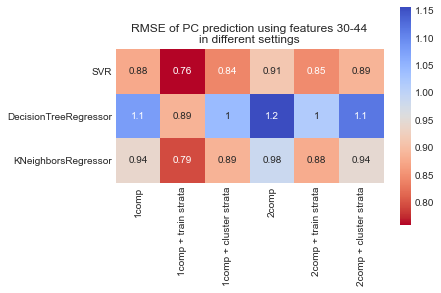

In [21]:
pcregr = PrincipalComponentRegressor()
pcs = pcregr.fit_predict_pca(x_pca, train_strata)

pcregr = PrincipalComponentRegressor(2)
pcs_2comp = pcregr.fit_predict_pca(x_pca, train_strata)

base_regressors = [SVR, DecisionTreeRegressor, KNeighborsRegressor]
index = [regressor.__name__ for regressor in base_regressors]
setups = ['1comp', '1comp + train strata', '1comp + cluster strata',
          '2comp', '2comp + train strata', '2comp + cluster strata']

scores = pd.DataFrame(index=index, columns=setups, dtype=float)
cv_scores = []

kfold = StratifiedKFold(5, shuffle=True)

for train_idx, test_idx in tqdm(kfold.split(x, train_strata), total=kfold.get_n_splits()):
    x_pca_train = x_pca[train_idx]
    x_pca_test = x_pca[test_idx]
    
    x_regressor_train = x_regressor[train_idx]
    x_regressor_test = x_regressor[test_idx]
    
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    train_strata_train = train_strata[train_idx]
    train_strata_test = train_strata[test_idx]
    
    cluster_strata_train = cluster_strata[train_idx]
    cluster_strata_test = cluster_strata[test_idx]
    
    pcs_train = pcs[train_idx]
    pcs_test = pcs[test_idx]

    pcs_2comp_train = pcs_2comp[train_idx]
    pcs_2comp_test = pcs_2comp[test_idx]
    
    scores_ = scores.copy()
    
    for i, base_regressor in enumerate(base_regressors):
        pcregr = PrincipalComponentRegressor(base_regressor=base_regressor)
        pcregr.fit_regressor(x_regressor_train, pcs_train)
        pcs_pred = pcregr.predict_regressor(x_regressor_test)
        scores_.iloc[i, 0] = mean_squared_error(pcs_test, pcs_pred) ** 0.5

        pcregr = PrincipalComponentRegressor(base_regressor=base_regressor)
        pcregr.fit_regressor(x_regressor_train, pcs_train, train_strata_train)
        pcs_pred = pcregr.predict_regressor(x_regressor_test, train_strata_test)
        scores_.iloc[i, 1] = mean_squared_error(pcs_test, pcs_pred) ** 0.5

        pcregr = PrincipalComponentRegressor(base_regressor=base_regressor)
        pcregr.fit_regressor(x_regressor_train, pcs_train, cluster_strata_train)
        pcs_pred = pcregr.predict_regressor(x_regressor_test, cluster_strata_test)
        scores_.iloc[i, 2] = mean_squared_error(pcs_test, pcs_pred) ** 0.5

        pcregr = PrincipalComponentRegressor(2, base_regressor=base_regressor)
        pcregr.fit_regressor(x_regressor_train, pcs_2comp_train)
        pcs_pred = pcregr.predict_regressor(x_regressor_test)
        scores_.iloc[i, 3] = mean_squared_error(pcs_2comp_test, pcs_pred) ** 0.5

        pcregr = PrincipalComponentRegressor(2, base_regressor=base_regressor)
        pcregr.fit_regressor(x_regressor_train, pcs_2comp_train, train_strata_train)
        pcs_pred = pcregr.predict_regressor(x_regressor_test, train_strata_test)
        scores_.iloc[i, 4] = mean_squared_error(pcs_2comp_test, pcs_pred) ** 0.5

        pcregr = PrincipalComponentRegressor(2, base_regressor=base_regressor)
        pcregr.fit_regressor(x_regressor_train, pcs_2comp_train, cluster_strata_train)
        pcs_pred = pcregr.predict_regressor(x_regressor_test, cluster_strata_test)
        scores_.iloc[i, 5] = mean_squared_error(pcs_2comp_test, pcs_pred) ** 0.5
    
    cv_scores.append(scores_)
    
scores = sum(cv_scores) / len(cv_scores)

sns.heatmap(scores, square=True, annot=True, cmap='coolwarm_r')
plt.title(f'RMSE of PC prediction using features {fit_cols[0]}-{fit_cols[-1]}\nin different settings')

plt.savefig(figures_dir / f'pca_prediction_{fit_cols[0]}_{fit_cols[-1]}.pdf',
            transparent=True, bbox_inches='tight')

То же самое по поездам.

  0%|          | 0/94 [00:00<?, ?it/s]

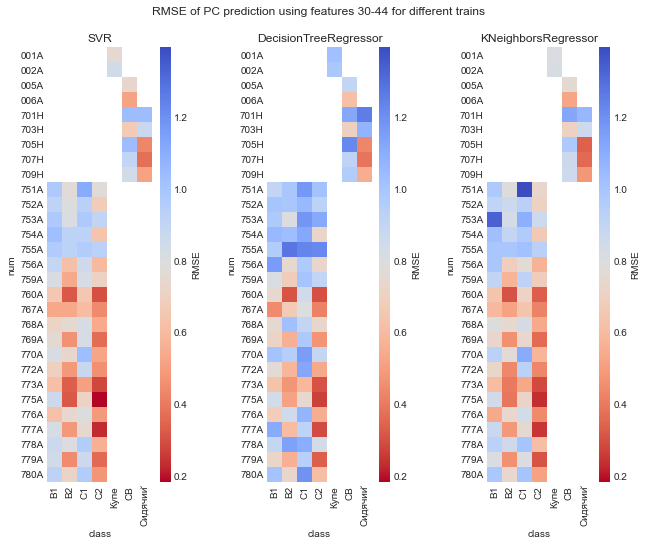

In [22]:
trains = places.index.get_level_values(0).unique()
base_regressors = [SVR, DecisionTreeRegressor, KNeighborsRegressor]

scores = {}

for train in tqdm(trains):
    mask = places.index.get_level_values(0) == train
    
    x = places[mask].values
    train_strata = places[mask].index.get_level_values(0).values
    cluster_strata = places[mask].index.get_level_values(0).map(train_clusters).values

    cols = np.arange(45)
    fit_cols = cols[-15:]
    predict_cols = cols[:-15]

    x_pca = x[:, cols]
    x_regressor = x[:, fit_cols]
    y = x[:, predict_cols]

    mask = ((~np.isnan(x_pca)).sum(axis=1) >= 3) & ((~np.isnan(x_regressor)).sum(axis=1) >= 3)

    x = x[mask]
    x_pca = x_pca[mask]
    x_regressor = x_regressor[mask]
    y = y[mask]
    
    pcregr = PrincipalComponentRegressor()
    pcs = pcregr.fit_predict_pca(x_pca)
    
    kfold = KFold(5, shuffle=True)
    
    scores_ = defaultdict(list)
    
    for train_idx, test_idx in kfold.split(x):
        x_pca_train = x_pca[train_idx]
        x_pca_test = x_pca[test_idx]

        x_regressor_train = x_regressor[train_idx]
        x_regressor_test = x_regressor[test_idx]

        y_train = y[train_idx]
        y_test = y[test_idx]

        train_strata_train = train_strata[train_idx]
        train_strata_test = train_strata[test_idx]

        cluster_strata_train = cluster_strata[train_idx]
        cluster_strata_test = cluster_strata[test_idx]

        pcs_train = pcs[train_idx]
        pcs_test = pcs[test_idx]
        
        for base_regressor in base_regressors:
            pcregr = PrincipalComponentRegressor(base_regressor=base_regressor)
            pcregr.fit_regressor(x_regressor_train, pcs_train)
            pcs_pred = pcregr.predict_regressor(x_regressor_test)
            score = mean_squared_error(pcs_test, pcs_pred) ** 0.5
            scores_[base_regressor.__name__].append(score)
            
    scores_ = pd.DataFrame(scores_).mean()
    scores[train] = scores_
    
scores = pd.DataFrame(scores).T

fig, axes = plt.subplots(ncols=len(scores.columns))
fig.set_size_inches(3.5 * len(scores.columns), 8)
fig.subplots_adjust(wspace=0.5)

vmin = scores.min().min()
vmax = scores.max().max()

for col, ax in zip(scores.columns, axes):
    df = scores[[col]].copy()
    df['num'] = scores.index.map(lambda s: s.split('-')[0])
    df['class'] = scores.index.map(lambda s: s.split('-')[1])
    df = df.pivot(index='num', columns='class', values=col)
    
    sns.heatmap(df, ax=ax, square=True, vmin=vmin, vmax=vmax,
                cmap='coolwarm_r', cbar_kws={'aspect': 40, 'label': 'RMSE'})
    
    ax.set_title(col)
    
plt.suptitle(f'RMSE of PC prediction using features {fit_cols[0]}-{fit_cols[-1]} for different trains', y=0.95)

plt.savefig(figures_dir / f'pca_prediction_{fit_cols[0]}_{fit_cols[-1]}_trains.pdf',
            transparent=True, bbox_inches='tight')

Наконец, тестируем опять модели целиком, варьируя сценарии (модель регрессии, число ГК, использование страт).

In [23]:
x = places.values

cols = np.arange(45)  # столбцы, которые будут использованы
fit_cols = cols[-15:]  # столбцы для фита
predict_cols = cols[:-15]  # столбцы для предикта

x_pca = x[:, cols]  # для обучения PCA используются все `cols`
x_regressor = x[:, fit_cols]
y = x[:, predict_cols]

# выкидываем строки, для которых в матрицах `x_pca` и `x_regressor` менее 2 непустых значений
mask = ((~np.isnan(x_pca)).sum(axis=1) >= 2) & ((~np.isnan(x_regressor)).sum(axis=1) >= 2)

x = x[mask]
x_pca = x_pca[mask]
x_regressor = x_regressor[mask]
y = y[mask]

# стратификация по поездам (т.е. для каждого поезда отдельная модель)
train_strata = places.index.get_level_values(0).values[mask]

# стратификация по кластерам из `2_weekends.ipynb`
cluster_strata = places.index.get_level_values(0).map(train_clusters).values[mask]

  0%|          | 0/5 [00:00<?, ?it/s]

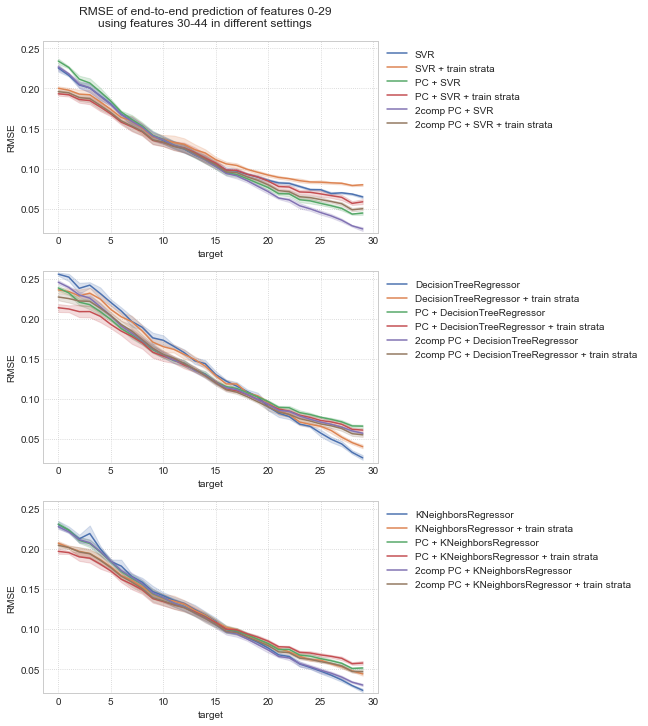

In [24]:
base_regressors = [SVR, DecisionTreeRegressor, KNeighborsRegressor]

results = []

kfold = StratifiedKFold(5, shuffle=True)

for train_idx, test_idx in tqdm(kfold.split(x, train_strata), total=kfold.get_n_splits()):
    x_pca_train = x_pca[train_idx]
    x_pca_test = x_pca[test_idx]
    
    x_regressor_train = x_regressor[train_idx]
    x_regressor_test = x_regressor[test_idx]
    
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    train_strata_train = train_strata[train_idx]
    train_strata_test = train_strata[test_idx]
    
    cluster_strata_train = cluster_strata[train_idx]
    cluster_strata_test = cluster_strata[test_idx]
    
    for base_regressor in base_regressors:
        regressor = Regressor(base_regressor=base_regressor).fit(x_regressor_train, y_train)
        y_pred = regressor.predict(x_regressor_test)
        scores = np.nanmean((y_test - y_pred) ** 2, axis=0) ** 0.5

        for col, score in zip(predict_cols, scores):
            results.append({
                'model': base_regressor.__name__,
                'target': col,
                'score': score,
            })
            
        regressor = Regressor(base_regressor=base_regressor).fit(x_regressor_train, y_train, train_strata_train)
        y_pred = regressor.predict(x_regressor_test, train_strata_test)
        scores = np.nanmean((y_test - y_pred) ** 2, axis=0) ** 0.5

        for col, score in zip(predict_cols, scores):
            results.append({
                'model': base_regressor.__name__ + ' + train strata',
                'target': col,
                'score': score,
            })
            
        pcregr = PrincipalComponentRegressor(base_regressor=base_regressor)
        pcregr.fit(x_pca_train, x_regressor_train)
        y_pred = pcregr.predict(x_regressor_test)[:, predict_cols]
        scores = np.nanmean((y_test - y_pred) ** 2, axis=0) ** 0.5

        for col, score in zip(predict_cols, scores):
            results.append({
                'model': 'PC + ' + base_regressor.__name__,
                'target': col,
                'score': score,
            })
                        
        pcregr = PrincipalComponentRegressor(base_regressor=base_regressor)
        pcregr.fit(x_pca_train, x_regressor_train,
                   strata_pca=train_strata_train, strata_regressor=train_strata_train)
        y_pred = pcregr.predict(x_regressor_test, strata_pca=train_strata_test,
                                strata_regressor=train_strata_test)[:, predict_cols]
        scores = np.nanmean((y_test - y_pred) ** 2, axis=0) ** 0.5

        for col, score in zip(predict_cols, scores):
            results.append({
                'model': 'PC + ' + base_regressor.__name__ + ' + train strata',
                'target': col,
                'score': score,
            })
            
        pcregr = PrincipalComponentRegressor(2, base_regressor=base_regressor)
        pcregr.fit(x_pca_train, x_regressor_train)
        y_pred = pcregr.predict(x_regressor_test)[:, predict_cols]
        scores = np.nanmean((y_test - y_pred) ** 2, axis=0) ** 0.5

        for col, score in zip(predict_cols, scores):
            results.append({
                'model': '2comp PC + ' + base_regressor.__name__,
                'target': col,
                'score': score,
            })
                        
        pcregr = PrincipalComponentRegressor(2, base_regressor=base_regressor)
        pcregr.fit(x_pca_train, x_regressor_train,
                   strata_pca=train_strata_train, strata_regressor=train_strata_train)
        y_pred = pcregr.predict(x_regressor_test, strata_pca=train_strata_test,
                                strata_regressor=train_strata_test)[:, predict_cols]
        scores = np.nanmean((y_test - y_pred) ** 2, axis=0) ** 0.5

        for col, score in zip(predict_cols, scores):
            results.append({
                'model': '2comp PC + ' + base_regressor.__name__ + ' + train strata',
                'target': col,
                'score': score,
            })

results = pd.DataFrame(results)

fig, axes = plt.subplots(nrows=len(base_regressors))
fig.set_size_inches(6, 4 * len(base_regressors))

vmin = results['score'].min()
vmax = results['score'].max()

for ax, base_regressor in zip(axes, base_regressors):
    mask = results['model'].str.contains(base_regressor.__name__)
    
    sns.lineplot(ax=ax, data=results[mask], x='target', y='score', hue='model')
    ax.set_ylim(vmin, vmax)

    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.set_ylabel('RMSE')

plt.suptitle(f'RMSE of end-to-end prediction of features {predict_cols[0]}-{predict_cols[-1]}\n'
             f'using features {fit_cols[0]}-{fit_cols[-1]} in different settings', y=0.92)

plt.savefig(figures_dir / f'prediction_{predict_cols[0]}_{predict_cols[-1]}_{fit_cols[0]}_{fit_cols[-1]}.pdf',
            transparent=True, bbox_inches='tight')

Несколько единичных примеров восстановления динамики заполняемости.

In [25]:
kfold = StratifiedKFold(5, shuffle=True)

for train_idx, test_idx in kfold.split(x, train_strata):
    x_pca_train = x_pca[train_idx]
    x_pca_test = x_pca[test_idx]
    
    x_regressor_train = x_regressor[train_idx]
    x_regressor_test = x_regressor[test_idx]
    
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    train_strata_train = train_strata[train_idx]
    train_strata_test = train_strata[test_idx]
    
    cluster_strata_train = cluster_strata[train_idx]
    cluster_strata_test = cluster_strata[test_idx]
    
    break

In [36]:
pcregr = PrincipalComponentRegressor().fit(
    x_pca_train, x_regressor_train, train_strata_train, train_strata_train)
y_pred = pcregr.predict(x_regressor_test, train_strata_test, train_strata_test)[:, predict_cols]

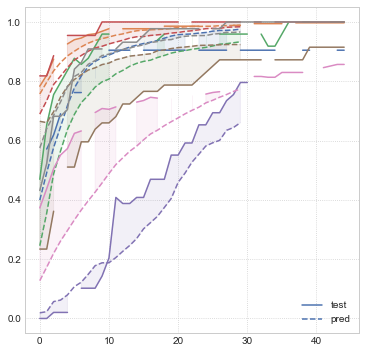

In [39]:
plt.figure(figsize=(6, 6))

idx = np.random.choice(np.arange(test_idx.size), size=8, replace=False)

for i, j in enumerate(idx):
    plt.plot(x_pca_test[j], c=f'C{i}', label='test' if i == 0 else None)
    plt.plot(y_pred[j], c=f'C{i}', ls='dashed', label='pred' if i == 0 else None)
    
    ox = np.arange(y_test[j].size)
    oy1 = y_test[j]
    oy2 = y_pred[j]
    
    plt.fill_between(ox, oy1, oy2, color=f'C{i}', alpha=0.1)
    
plt.legend()

plt.savefig(figures_dir / 'prediction_examples.pdf', transparent=True, bbox_inches='tight')